In [27]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from tqdm.notebook import tqdm

In [28]:
api = wandb.Api()

In [64]:
sweep_ids = ("9as7up1f",)
sweeps = [api.sweep(f"project-avengers/goon-test/sweeps/{sweep_id}") for sweep_id in sweep_ids]

In [65]:
results = []
for s in sweeps:
    runs = s.runs
    for r in tqdm(runs):
        if r.state == "finished":
            config = deepcopy(r.config)
            last_loss =[x for x in r.scan_history(min_step=config["num_steps"], keys=["loss"])]
            assert len(last_loss) == 1
            config["loss"] = last_loss[0]["loss"]
            results.append(config)

  0%|          | 0/204 [00:00<?, ?it/s]

In [66]:
results_df = pd.DataFrame(results)
results_df

,mup,optim,d_model,n_layer,tracker,weights,col_name,datasets,head_dim,acc_steps,...,batch_size,seq_length,vocab_size,learning_rate,tokenizer_path,report_interval,mup_base_d_model,use_torch_compile,mup_simple_scaling_impl,loss
0,False,sgd,8196,4,wandb,1,contents,dataset=cc_en_head,128,16,...,4,512,128256,0.010000,/datasets/tokenizers/llama3,64,256,False,False,7.556309
1,True,sgd,8196,4,wandb,1,contents,dataset=cc_en_head,128,16,...,4,512,128256,0.010000,/datasets/tokenizers/llama3,64,256,False,False,9.831264
2,False,sgd,8196,4,wandb,1,contents,dataset=cc_en_head,128,16,...,4,512,128256,0.017783,/datasets/tokenizers/llama3,64,256,False,False,7.380943
3,False,sgd,8196,4,wandb,1,contents,dataset=cc_en_head,128,16,...,4,512,128256,0.056234,/datasets/tokenizers/llama3,64,256,False,False,6.969914
4,True,sgd,8196,4,wandb,1,contents,dataset=cc_en_head,128,16,...,4,512,128256,0.017783,/datasets/tokenizers/llama3,64,256,False,False,9.201571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,False,sgd,256,4,wandb,1,contents,dataset=cc_en_head,128,16,...,4,512,128256,10.000000,/datasets/tokenizers/llama3,64,256,False,False,7.734782
200,False,sgd,256,4,wandb,1,contents,dataset=cc_en_head,128,16,...,4,512,128256,5.623413,/datasets/tokenizers/llama3,64,256,False,False,6.529698
201,False,sgd,256,4,wandb,1,contents,dataset=cc_en_head,128,16,...,4,512,128256,56.234133,/datasets/tokenizers/llama3,64,256,False,False,10.237527
202,False,sgd,256,4,wandb,1,contents,dataset=cc_en_head,128,16,...,4,512,128256,100.000000,/datasets/tokenizers/llama3,64,256,False,False,19.078943


In [67]:
non_nan_results_df = results_df[results_df.loss != "NaN"]
print(f"Removed {len(results_df) - len(non_nan_results_df)} NaNs")

Removed 10 NaNs


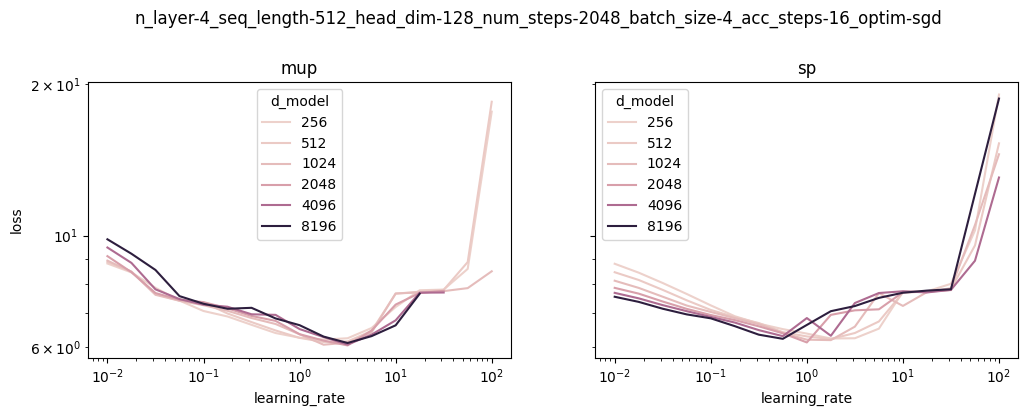

In [68]:
fig, axs = plt.subplots(                                                  
 ncols=2, nrows=1, sharey=True, sharex=True, figsize=(6 * 2, 4 ) 
)                                                                         
mup_plot =sns.lineplot(data=non_nan_results_df[non_nan_results_df.mup], x="learning_rate", y="loss", hue="d_model", ax=axs[0])
axs[0].set_title("mup")
no_mup_plot = sns.lineplot(data=non_nan_results_df[~non_nan_results_df.mup], x="learning_rate", y="loss", hue="d_model", ax=axs[1])
axs[1].set_title("sp")
mup_plot.set(xscale="log")
mup_plot.set(yscale="log")
no_mup_plot.set(xscale="log")
no_mup_plot.set(yscale="log")

suptitle = f'n_layer-{config["n_layer"]}_seq_length-{config["seq_length"]}_head_dim-{config["head_dim"]}_num_steps-{config["num_steps"]}_batch_size-{config["batch_size"]}_acc_steps-{config["acc_steps"]}_optim-{config["optim"]}'

fig.suptitle(suptitle)
fig.subplots_adjust(top=0.8)
fig.savefig(suptitle + ".png", dpi=256, bbox_inches="tight")